In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
infos_df = pd.read_csv('/content/drive/My Drive/DMC2020/infos.csv', sep='|')
items_df = pd.read_csv('/content/drive/My Drive/DMC2020/items.csv', sep='|')
orders_df = pd.read_csv('/content/drive/My Drive/DMC2020/orders.csv', sep='|')

In [0]:
import pandas as pd
import numpy as np
from itertools import product
from tqdm import tqdm_notebook

def create_item_perDay_df(orders_df, infos_df, items_df):

  df = pd.DataFrame(list(product(infos_df['itemID'], pd.date_range(start='01-01-2018', end='06-29-2018'))), columns=['itemID', 'date'])

  date_df = pd.DataFrame(pd.date_range(start='01-01-2018', end='06-29-2018'), columns=['date'])
  date_df['week'] = date_df['date'].dt.week.shift(-2, fill_value=26)

  df = df.merge(date_df, how='outer', on='date')

  orders_df['date'] = pd.to_datetime(orders_df['time']).dt.date
  orders_df = orders_df.groupby(['date', 'itemID']).aggregate({'order':np.sum,'salesPrice':np.mean}).reset_index()
  orders_df['date'] = pd.to_datetime(orders_df['date'])

  df = pd.merge(df, orders_df, how='outer', on=['date','itemID'])

  for i in tqdm_notebook(range(1,10464,1)):
    item = df.loc[df['itemID'] == i]
    item['salesPrice'].fillna(method='ffill', inplace=True)
    item['salesPrice'].fillna(method='bfill', inplace=True)
    item.fillna(infos_df['simulationPrice'].loc[infos_df['itemID']==i], inplace=True)
    df.loc[df['itemID'] == i] = item


  df.fillna(0, inplace=True)

  return df.merge(items_df, how='outer', on='itemID')

In [25]:
data = create_item_perDay_df(orders_df, infos_df, items_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [0]:
df = data

In [0]:
df['Day'] = pd.Index(df['date']).day
df['Dayofweek'] = pd.Index(df['date']).dayofweek
df['Month'] = pd.Index(df['date']).month
df['DateInt'] = df['date'].astype(np.int64)

In [31]:
df

,itemID,date,week,order,salesPrice,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,Day,Dayofweek,Month,DateInt
0,1,2018-01-01,1,0.0,3.11,0,1,4.38,1,1,1,8.84,1,0,1,1514764800000000000
1,1,2018-01-02,1,0.0,3.11,0,1,4.38,1,1,1,8.84,2,1,1,1514851200000000000
2,1,2018-01-03,1,0.0,3.11,0,1,4.38,1,1,1,8.84,3,2,1,1514937600000000000
3,1,2018-01-04,1,0.0,3.11,0,1,4.38,1,1,1,8.84,4,3,1,1515024000000000000
4,1,2018-01-05,1,0.0,3.11,0,1,4.38,1,1,1,8.84,5,4,1,1515110400000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883335,10463,2018-06-25,26,0.0,282.16,0,253,0.00,8,44,8,154.82,25,0,6,1529884800000000000
1883336,10463,2018-06-26,26,0.0,282.16,0,253,0.00,8,44,8,154.82,26,1,6,1529971200000000000
1883337,10463,2018-06-27,26,0.0,282.16,0,253,0.00,8,44,8,154.82,27,2,6,1530057600000000000
1883338,10463,2018-06-28,26,0.0,282.16,0,253,0.00,8,44,8,154.82,28,3,6,1530144000000000000


In [0]:
def score(predictions, y_test, salesPrice):
  # predictions,y_test,salesPrice array with equal length and value (order/Price) sorted by itemID ascending

  pred_sales = 0
  pred_cost = 0
  test_sales = 0


  for i in range(0, len(predictions), 1):

    if (predictions[i] <= y_test[i]): # without overstocking fee
      pred_sales += predictions[i] * salesPrice[i]

    else: # with overstocking fee
      pred_sales += y_test[i] * salesPrice[i]
      pred_cost += ((predictions[i]-y_test[i]) * salesPrice[i] * 0.6)

    test_sales += y_test[i] * salesPrice[i] # test orders

  return pred_sales, pred_cost, test_sales

In [0]:
train = df[df['week']<25]
test = df[df['week']>=25]

In [34]:
train

,itemID,date,week,order,salesPrice,brand,manufacturer,customerRating,category1,category2,category3,recommendedRetailPrice,Day,Dayofweek,Month,DateInt
0,1,2018-01-01,1,0.0,3.11,0,1,4.38,1,1,1,8.84,1,0,1,1514764800000000000
1,1,2018-01-02,1,0.0,3.11,0,1,4.38,1,1,1,8.84,2,1,1,1514851200000000000
2,1,2018-01-03,1,0.0,3.11,0,1,4.38,1,1,1,8.84,3,2,1,1514937600000000000
3,1,2018-01-04,1,0.0,3.11,0,1,4.38,1,1,1,8.84,4,3,1,1515024000000000000
4,1,2018-01-05,1,0.0,3.11,0,1,4.38,1,1,1,8.84,5,4,1,1515110400000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1883321,10463,2018-06-11,24,0.0,282.16,0,253,0.00,8,44,8,154.82,11,0,6,1528675200000000000
1883322,10463,2018-06-12,24,0.0,282.16,0,253,0.00,8,44,8,154.82,12,1,6,1528761600000000000
1883323,10463,2018-06-13,24,0.0,282.16,0,253,0.00,8,44,8,154.82,13,2,6,1528848000000000000
1883324,10463,2018-06-14,24,0.0,282.16,0,253,0.00,8,44,8,154.82,14,3,6,1528934400000000000


In [0]:
X_train, X_test = train.drop(['order','date'], axis=1), test.drop(['order','date'], axis=1)
y_train, y_test= train['order'].values, test['order'].values

In [0]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor()
model.fit(X_train,y_train)
pred = model.predict(X_test)

In [50]:
pred1 = test[['itemID','order']]
pred1['pred'] = pred
pred1 = pred1.groupby(['itemID']).sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
x,y,z = score(pred1['pred'].values, pred1['order'].values, infos_df['simulationPrice'].values)

In [57]:
x/z*100

23.190676335555313

In [58]:
-y/z*100

-96.12420098546146

Feature ranking:
1. feature 2 (0.185942) salesPrice
2. feature 0 (0.177816) itemID
3. feature 13 (0.147304) DateInt
4. feature 10 (0.118356) Day
5. feature 9 (0.100198) recommendedRetailPrice
6. feature 11 (0.061001) Dayofweek
7. feature 1 (0.054811) week
8. feature 4 (0.042640) manufacturer
9. feature 5 (0.037857) customerRating
10. feature 3 (0.028730) brand
11. feature 12 (0.021793) Month
12. feature 7 (0.017675) category2
13. feature 6 (0.003575) category1
14. feature 8 (0.002301) category3


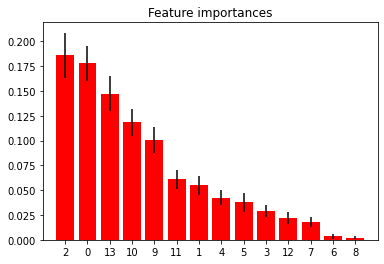

In [37]:
'importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])+' '+str(X_train.columns[indices[f]]))
    
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()